In [73]:
import numpy as np
import mpmath as mp
import renormalization as rg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [37]:
mp.mp.dps = 30
mp.mp.pretty = True

# Transfer matrix for spin-s Ising model

In [38]:
s = .5

T = 1
t = rg.transfer_matrix(s, 1/T)
print(t)

[[1.0 0.135335283236612691893999494972]
 [0.135335283236612691893999494972 1.0]]


# Renormalization group flow

In [67]:
s = 0.5 # Spin number s
T = .1 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for i in range(int((1 - p) * N)):
    t_list.append(ferro)
for i in range(int(p * N)):
    t_list.append(aferro)

j = rg.element_ratio(t_list[ij])
X = rg.element_ratio(t_list[ij]) / rg.average_element_ratio_strength(t_list)

print("k    J(ij) / <|J|>      J(ij) \n")
print(0, "   ", X, "             ", j)

ij = 19
flow = [[0, X]]
for k in range(1, 30):
    
    t_list = rg.renormalize(N, t_list)
    
    j = rg.element_ratio(t_list[ij])
    j_absavr = rg.average_element_ratio_strength(t_list)
    X = j / j_absavr
    flow.append([k, X])
    print(k, "   ", X, "    ", j)
    
flow = np.array(flow)

k    J(ij) / <|J|>      J(ij) 

0     1.0               20.0
1     0.781104078413494176707946561133      19.9999999999999999915032914894
2     0.568032729731367816207303635115      17.7313164586816357117007607134
3     -0.446190478759716493926734068992      -16.8162072407713505846411615064
4     -0.955820884917107379956121749586      -45.9965053048490822586042453021
5     -0.50477374280308179535723388511      -29.8690864245286296472846780978
6     0.417321763742796793663631871862      32.5217735749296791848114793049
7     -0.435702668188514730795897273709      -41.7313155210200628528559569536
8     0.34316999297043584604346539499      40.8289073099478179829604920138
9     4.18694462036797293477755749211      690.029145312599473985926653375
10     0.277105417443596659975041204712      58.9501870935883979954520299944
11     0.0576071564423036907509793175414      15.7301000473900546742816221944
12     0.936933384571954974996938525383      336.653750393575590478295649032
13     0.755731789

## RG trajectory plot

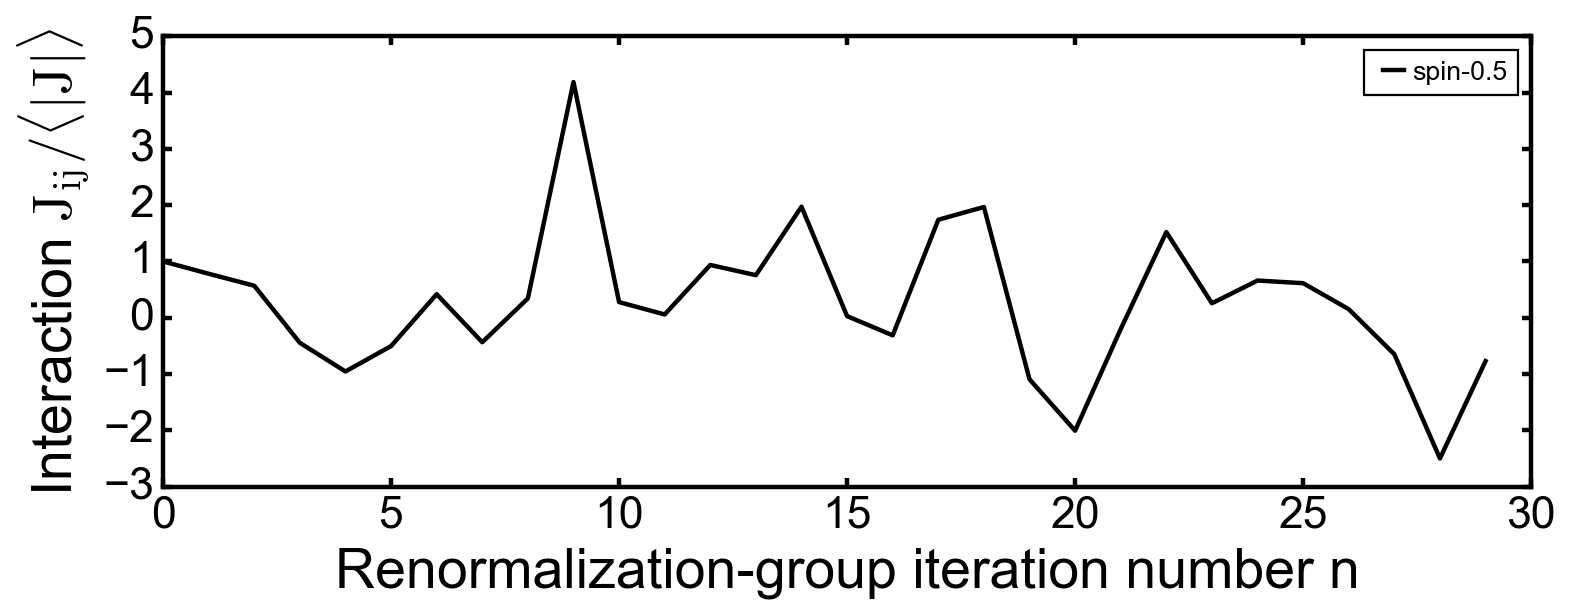

In [82]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')

ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=linewidths, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs + 5)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs + 5)
plt.tight_layout()
plt.show()